## Imports

In [1]:
import scipy.signal as signal
from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LambdaCallback, TensorBoard, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import random

import datetime
import os
import numpy as np
import wfdb
import matplotlib.pyplot as plt

from keras import layers, models, regularizers

from tensorflow.keras import layers, models, regularizers

np.random.seed(42)

import keras_tuner as kt

## Utils

In [2]:
# plotting
def plot_signals_in_grid(predicted_signals, true_signals, labels=['Predicted', 'True']):
    fig, axs = plt.subplots(len(predicted_signals)//2, 2, figsize=(20, 50))
    axs = axs.flatten() 

    for i in range(len(predicted_signals)):  
        ax = axs[i]
        pred_signal = predicted_signals[i]
        true_signal = true_signals[i]

        # Plotting both signals in the same subplot
        ax.plot(pred_signal, label=labels[0])
        ax.plot(true_signal, label=labels[1], alpha=0.75)
        ax.legend()
        ax.set_title(f'Example {i+1}')
    
    plt.tight_layout()
    plt.show()

In [3]:
# cross-correlation metric
def cross_correlation(y_true, y_pred):
    """ Compute cross-correlation between true and predicted signals. """
    y_true_mean = tf.reduce_mean(y_true, axis=1, keepdims=True)
    y_pred_mean = tf.reduce_mean(y_pred, axis=1, keepdims=True)
    
    y_true_std = tf.math.reduce_std(y_true, axis=1, keepdims=True)
    y_pred_std = tf.math.reduce_std(y_pred, axis=1, keepdims=True)

    norm_y_true = (y_true - y_true_mean) / y_true_std
    norm_y_pred = (y_pred - y_pred_mean) / y_pred_std

    correlation = tf.reduce_mean(norm_y_true * norm_y_pred, axis=1)
    return tf.reduce_mean(correlation)

In [4]:
# visualise predictions
import io
class VisualiseCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, frequency=20):
        super(VisualiseCallback, self).__init__()
        self.log_dir = log_dir
        self.writer = tf.summary.create_file_writer(log_dir)
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            fig, ax = plt.subplots(2, 2, figsize=(12, 8))
            fig.suptitle('Ground truth vs. Prediction')
    
            for row in range(2):
                train_idx = np.random.randint(0, windows_ecg_train.shape[0])
                val_idx = np.random.randint(0, windows_ecg_validation.shape[0])
    
                to_predict_train = np.array([windows_ecg_train[train_idx]])
                ground_truth_train = windows_resp_train[train_idx]
                prediction_train = self.model.predict(to_predict_train)[0]
                prediction_train_score = self.model.evaluate(to_predict_train, np.array([ground_truth_train]), verbose=0)
    
                to_predict_validation = np.array([windows_ecg_validation[val_idx]])
                ground_truth_validation = windows_resp_validation[val_idx]
                prediction_validation = self.model.predict(to_predict_validation)[0]
                prediction_validation_score = self.model.evaluate(to_predict_validation, np.array([ground_truth_validation]), verbose=0)
    
                ax[row, 0].plot(ground_truth_train, label='Ground Truth')
                ax[row, 0].plot(prediction_train, label='Prediction')
                ax[row, 0].set_title(f"Train Loss: {prediction_train_score[0]:.4f} CC: {prediction_train_score[1]:.4f}")
                ax[row, 0].legend()
    
                ax[row, 1].plot(ground_truth_validation, label='Ground Truth')
                ax[row, 1].plot(prediction_validation, label='Prediction')
                ax[row, 1].set_title(f"Valid Loss: {prediction_validation_score[0]:.4f} CC: {prediction_validation_score[1]:.4f}")
                ax[row, 1].legend()
    
            plt.tight_layout()
            # Convert the matplotlib plot to a PNG image and then to a Tensor
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            plt.close(fig)
            buf.seek(0)
            image = tf.image.decode_png(buf.getvalue(), channels=4)
            image = tf.expand_dims(image, 0)
    
            # Log the image to TensorBoard
            with self.writer.as_default():
                tf.summary.image("Predictions vs. Ground Truth", image, step=epoch)
    
            self.writer.flush()

## Data Loading - Fantasia

In [5]:
def load_fantasia():
    files = os.listdir("/Users/lanacaldarevic/workspace/phd/biosignal_deeplearning/fantasia-database-1.0.0/")
    files = [s.replace('.dat', '') for s in files if ".dat" in s]
    
    data_fantasia = {}
    patients_fantasia = []
    
    for i, participant in enumerate(files):
        patients_fantasia.append(participant)
    
        data, info = wfdb.rdsamp("/Users/lanacaldarevic/workspace/phd/biosignal_deeplearning/fantasia-database-1.0.0/" + participant)
    
        # Get signal
        data = pd.DataFrame(data, columns=info["sig_name"])
        data_fantasia[participant] = np.array([data["ECG"], data["RESP"]])

    return data_fantasia, patients_fantasia

In [6]:
data, patients = load_fantasia()

## Data Processing

In [7]:
def process_data_segment(data, window_size, downsampled_window_size, patient_indices):
    overlap = 1 / 2

    windows_ecg = []
    windows_resp = []

    for record_index in patient_indices:
        N = len(data[record_index][0, :])
        max_step = int(N // (window_size * overlap))
        for step in range(1, max_step - 1):
            start_idx = int(step) * int(window_size * overlap)
            end_idx = start_idx + window_size
            recrd_ecg = data[record_index][0, start_idx:end_idx]
            recrd_resp = data[record_index][1, start_idx:end_idx]

            if recrd_ecg.min() < recrd_ecg.max():
                normalized_ecg = (recrd_ecg - recrd_ecg.min()) / (recrd_ecg.max() - recrd_ecg.min())
                normalized_ecg = signal.resample(normalized_ecg, downsampled_window_size)

                if recrd_resp.min() < recrd_resp.max():
                    normalized_resp = (recrd_resp - recrd_resp.min()) / (recrd_resp.max() - recrd_resp.min())
                    normalized_resp = signal.resample(normalized_resp, downsampled_window_size)
                    
                    windows_ecg.append(np.float32(normalized_ecg))
                    windows_resp.append(np.float32(normalized_resp))

    windows_ecg = np.array(windows_ecg)[:, :, np.newaxis]
    windows_resp = np.array(windows_resp)[:, :, np.newaxis]

    print(windows_ecg.shape)
    print(windows_resp.shape)

    return windows_ecg, windows_resp

In [8]:
train_val_patients, test_patients = train_test_split(patients, test_size=0.20, random_state=42)
train_val_patients_array = np.array(train_val_patients)

train_patients, val_patients = train_test_split(train_val_patients, test_size=0.20, random_state=42)

In [9]:
len(train_patients), len(val_patients), len(test_patients)

(25, 7, 8)

(45183, 1024, 1)
(45183, 1024, 1)
(12157, 1024, 1)
(12157, 1024, 1)
(14215, 1024, 1)
(14215, 1024, 1)


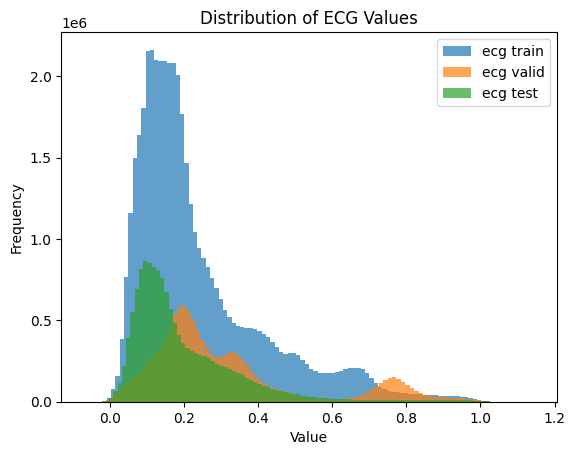

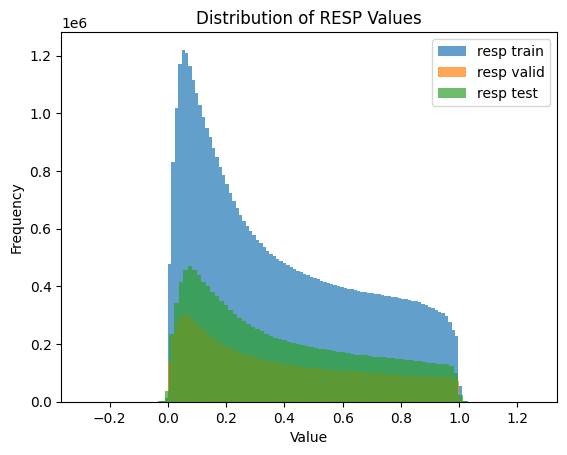

In [16]:
sampling_rate = 250
seconds_window = 8
downsampled_window_size = 1024 # signal size
window_size = sampling_rate * seconds_window # window size to split by

windows_ecg_train, windows_resp_train = process_data_segment(data, window_size, downsampled_window_size, train_patients)
windows_ecg_validation, windows_resp_validation = process_data_segment(data, window_size, downsampled_window_size, val_patients)
windows_ecg_test, windows_resp_test = process_data_segment(data, window_size, downsampled_window_size, test_patients)

plt.hist(windows_ecg_train.flatten(), bins=100, alpha=0.7, label="ecg train")
plt.hist(windows_ecg_validation.flatten(), bins=100, alpha=0.7, label="ecg valid")
plt.hist(windows_ecg_test.flatten(), bins=100, alpha=0.7, label="ecg test")
plt.title('Distribution of ECG Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.hist(windows_resp_train.flatten(), bins=100, alpha=0.7, label="resp train")
plt.hist(windows_resp_validation.flatten(), bins=100, alpha=0.7, label="resp valid")
plt.hist(windows_resp_test.flatten(), bins=100, alpha=0.7, label="resp test")
plt.title('Distribution of RESP Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Data Visualisation

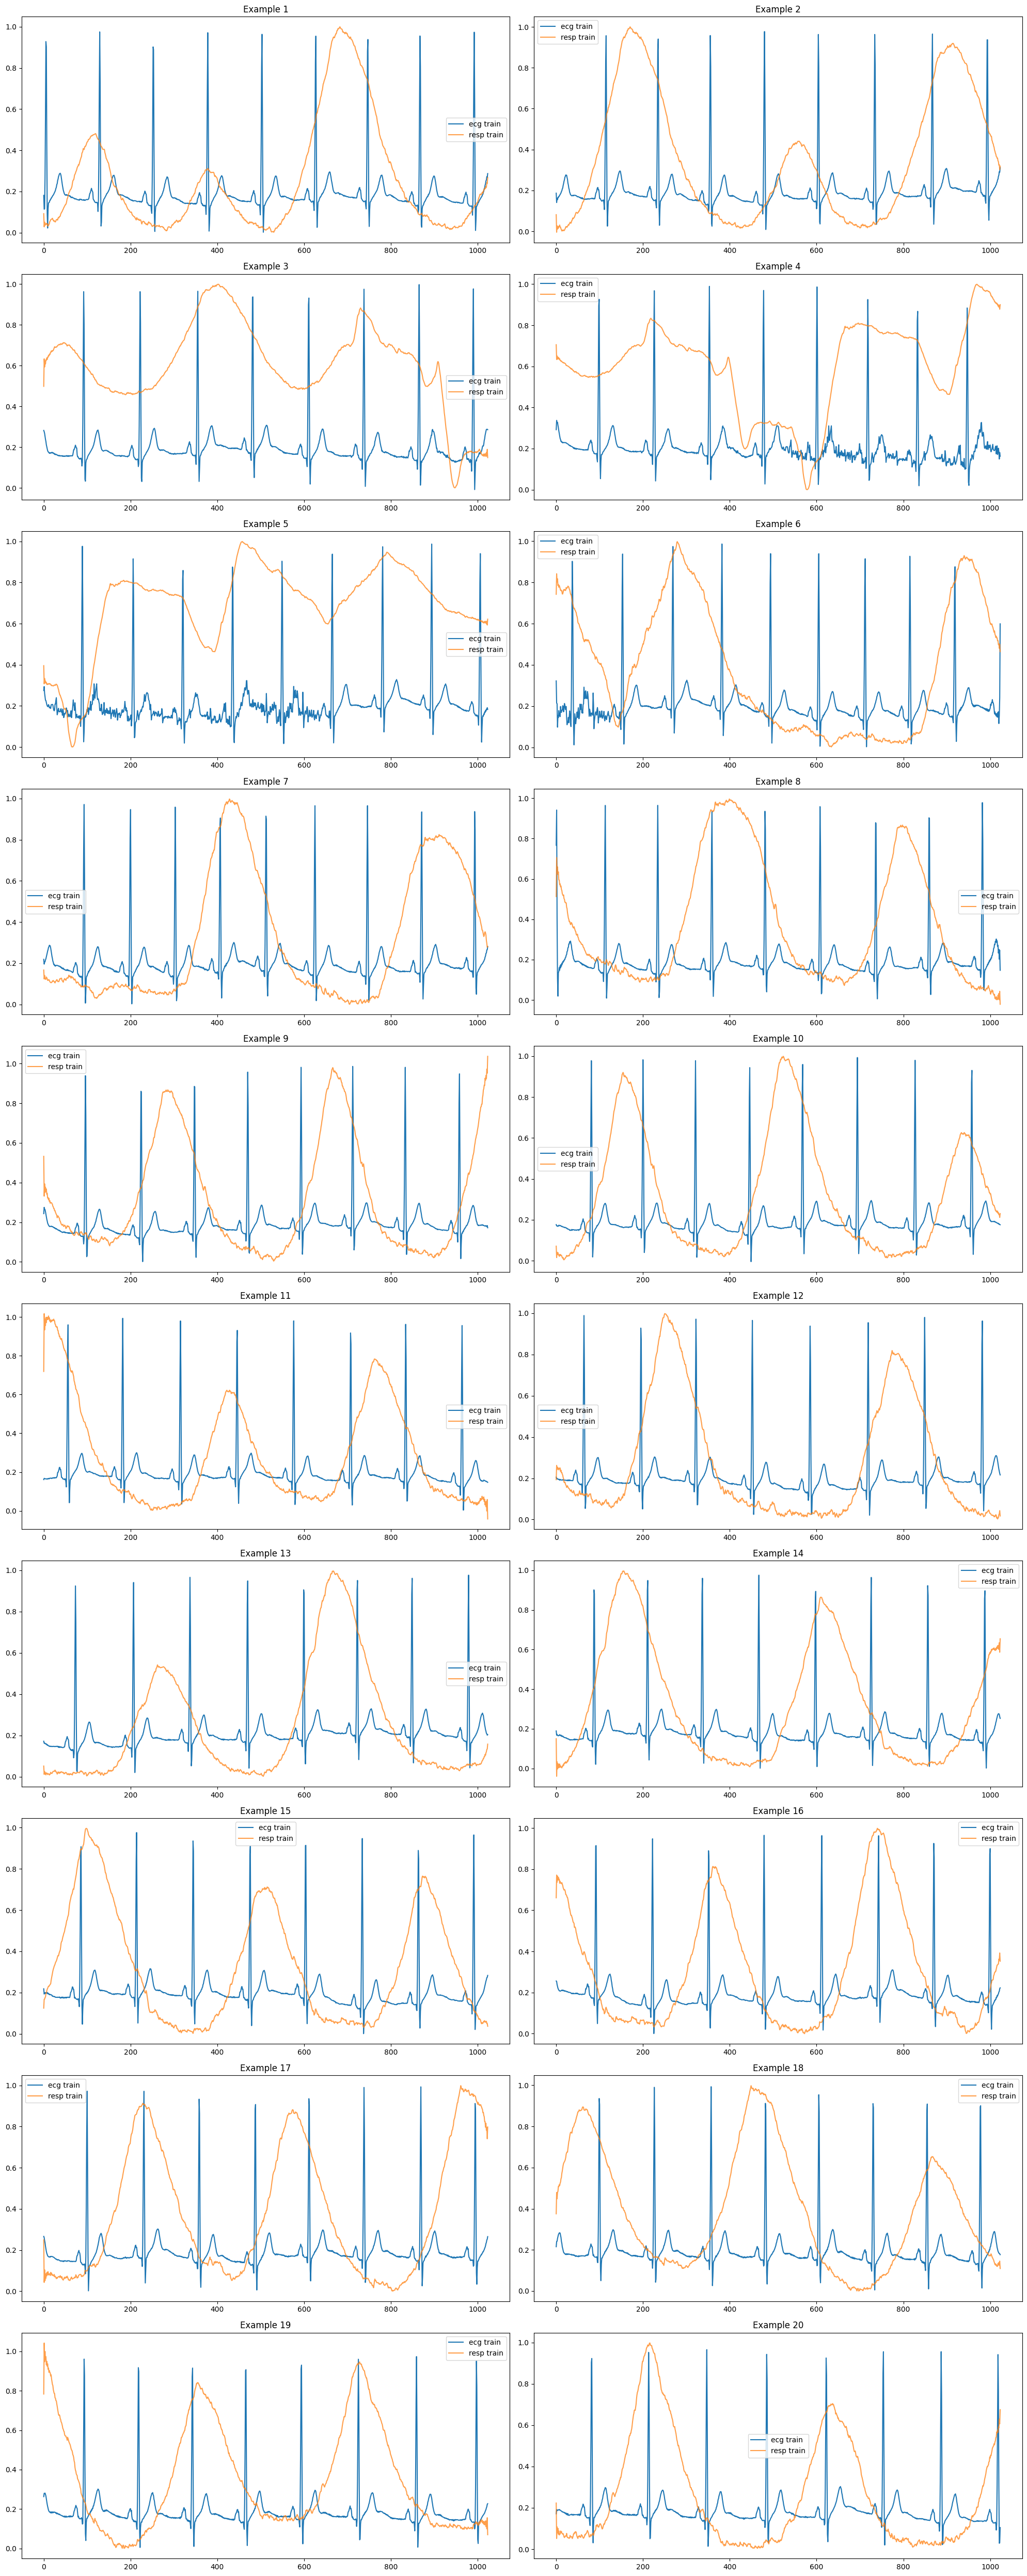

In [11]:
# train
plot_signals_in_grid(windows_ecg_train[0:20], windows_resp_train[0:20], labels=['ecg train', 'resp train'])

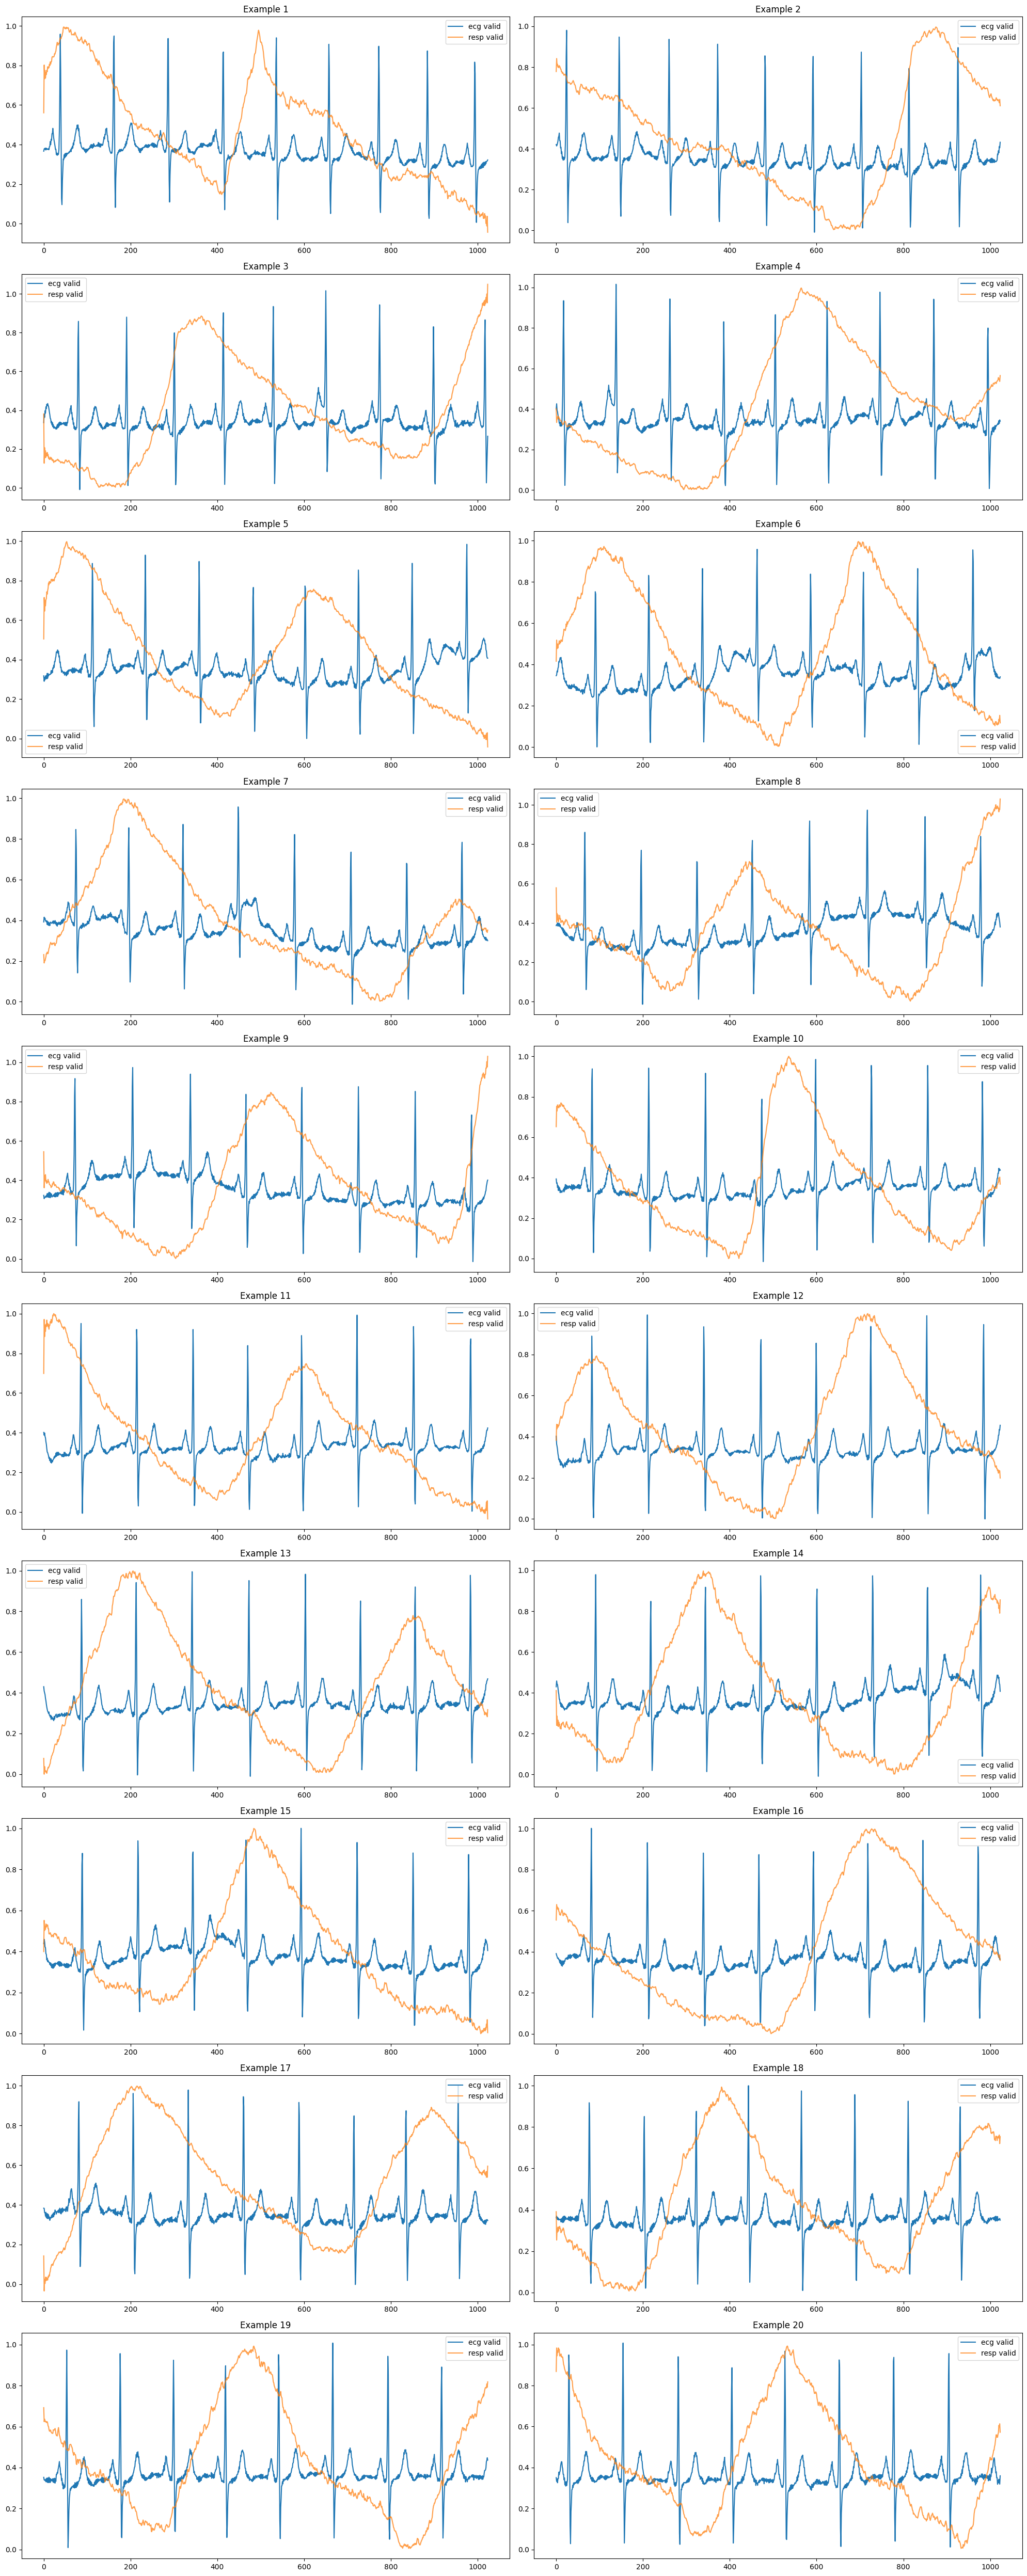

In [12]:
# valid
plot_signals_in_grid(windows_ecg_validation[0:20], windows_resp_validation[0:20], labels=['ecg valid', 'resp valid'])

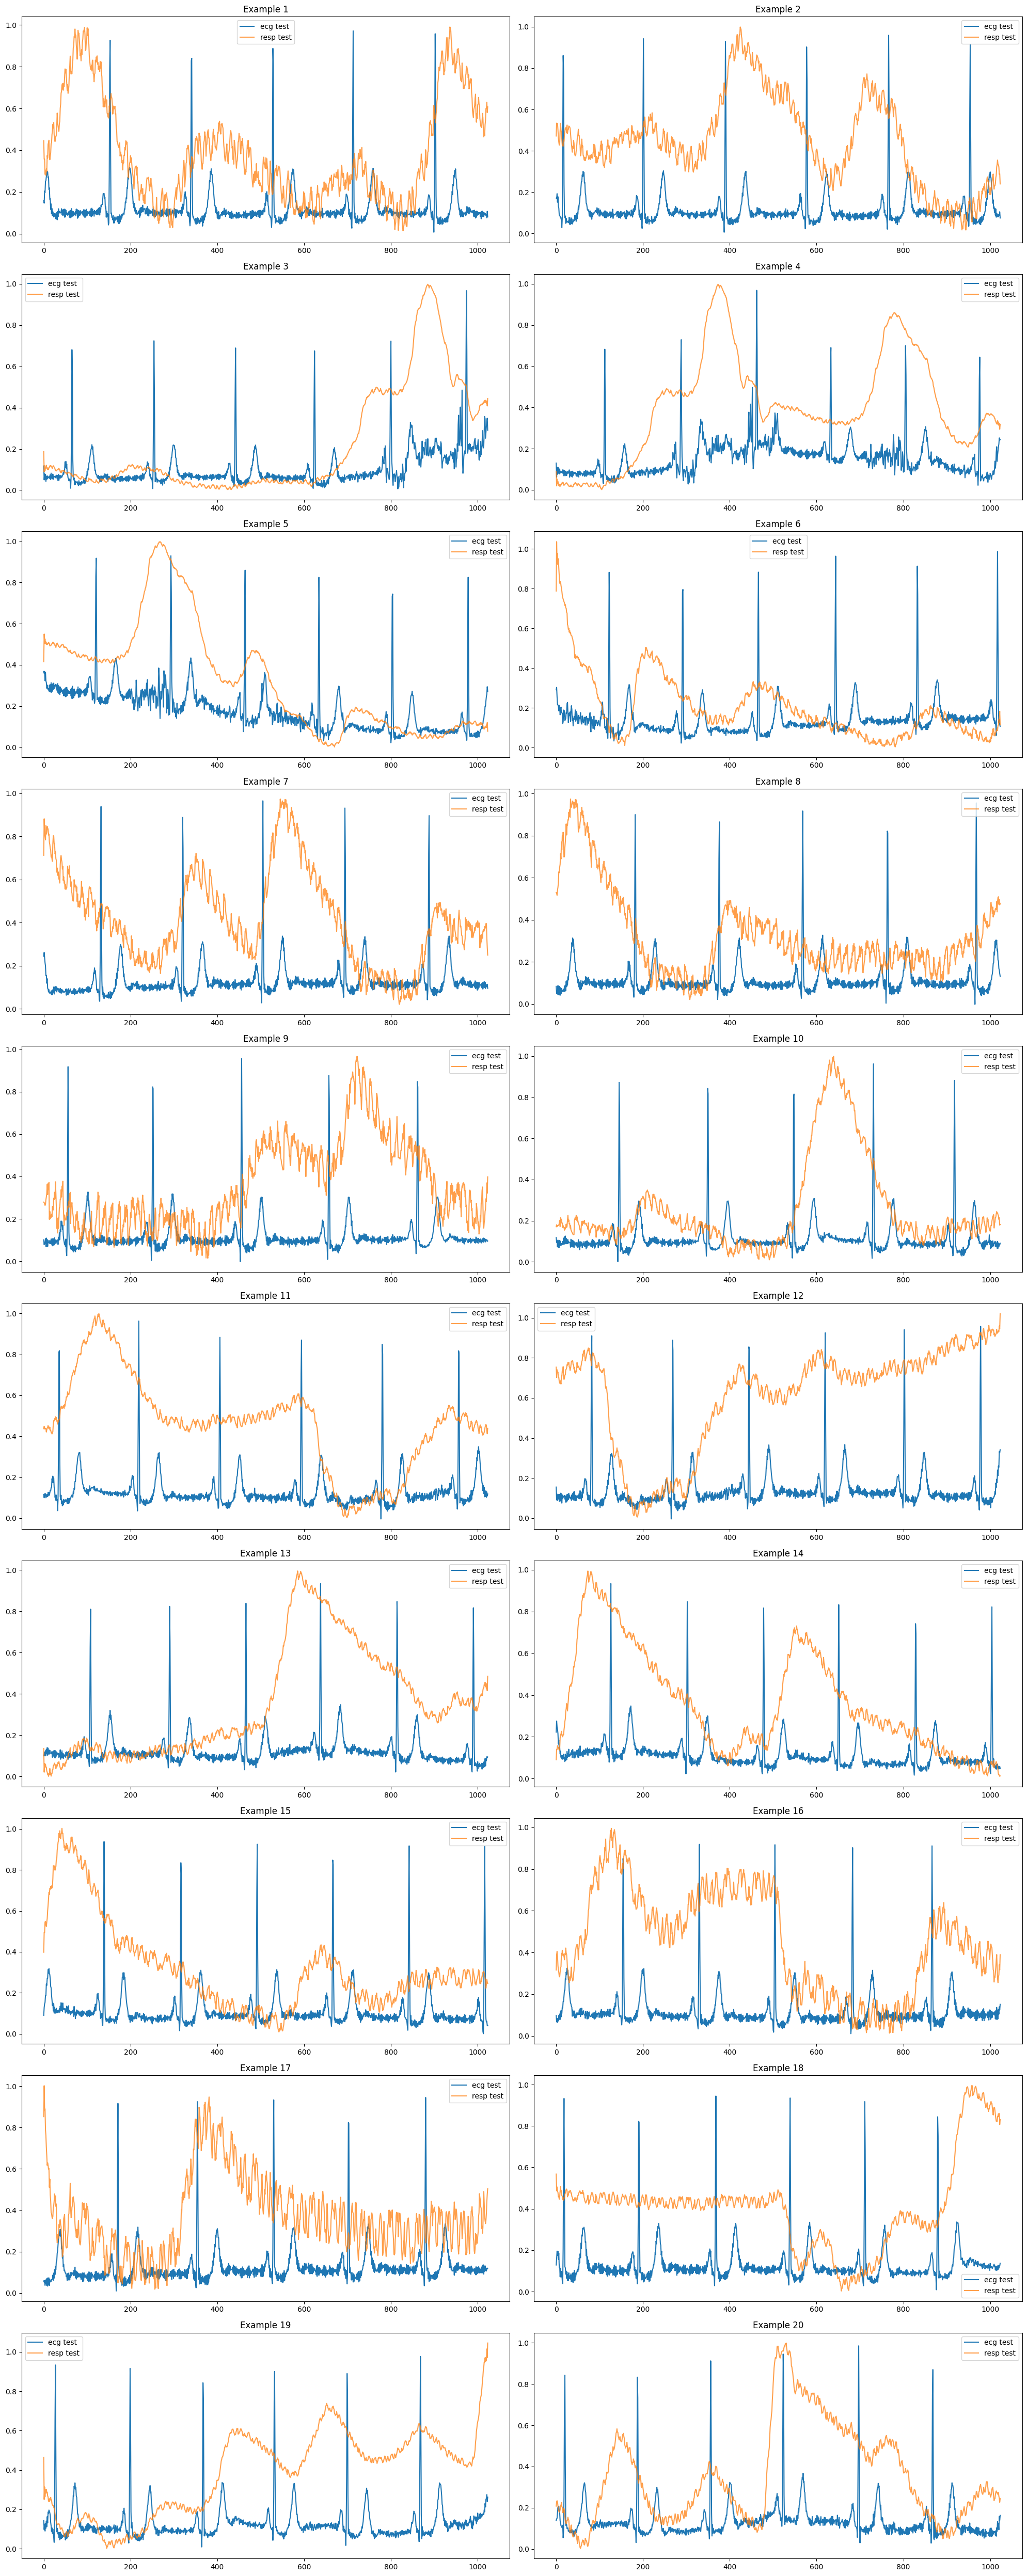

In [13]:
# test
plot_signals_in_grid(windows_ecg_test[0:20], windows_resp_test[0:20], labels=['ecg test', 'resp test'])

- too noisy?

In [14]:
if tf.config.list_physical_devices('GPU'):
    print("GPU enabled")
    with tf.device('/GPU:0'):
        windows_ecg_train = tf.convert_to_tensor(windows_ecg_train, dtype=tf.float16)
        windows_resp_train = tf.convert_to_tensor(windows_resp_train, dtype=tf.float16)
        windows_ecg_validation = tf.convert_to_tensor(windows_ecg_validation, dtype=tf.float16)
        windows_resp_validation = tf.convert_to_tensor(windows_resp_validation, dtype=tf.float16)
        windows_ecg_test = tf.convert_to_tensor(windows_ecg_test, dtype=tf.float16)
        windows_resp_test = tf.convert_to_tensor(windows_resp_test, dtype=tf.float16)

GPU enabled


2024-05-07 08:16:33.123056: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-07 08:16:33.123081: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-07 08:16:33.123090: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-07 08:16:33.123169: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-07 08:16:33.123182: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## CNN Autoencoder

In [ ]:
class ModelConfig:
    def __init__(self, kernel_size, reg, dropout, start_filters, batch_size, epochs, learning_rate, input_size):
        self.kernel_size = kernel_size
        self.reg = reg
        self.dropout = dropout
        self.start_filters = start_filters
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.input_size = input_size

    def __getitem__(self, item):
        return getattr(self, item)

    def __setitem__(self, key, value):
        setattr(self, key, value)

In [ ]:
# for hyperoptimization tuning
def model_builder(hp):
    kernel_size =  hp.Choice('kernel_size', values=[27])
    regularizer = regularizers.l2(hp.Float('l2_regularization', min_value=3e-4, max_value=1e-2, sampling='LOG'))
    learning_rate = hp.Float('learning_rate', min_value=3e-5, max_value=1e-2, sampling='LOG')
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.9, step=0.3)
    size_0 =  hp.Choice('start_filters', values=[8])

    # Input layer
    in_data = layers.Input(shape=(1024, 1))

    # Encoder part
    conv0 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(in_data)
    conv0 = layers.BatchNormalization()(conv0)
    conv0 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv0)
    conv0 = layers.BatchNormalization()(conv0)
    pool0 = layers.MaxPooling1D(pool_size=2)(conv0)

    size_1 = size_0 * 2
    conv1 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(pool0)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Dropout(dropout_rate)(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2)(conv1)

    size_2 = size_1 * 2
    conv2 = layers.Conv1D(size_2, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv1D(size_2, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = layers.BatchNormalization()(conv2)

    # Decoder part
    up1 = layers.UpSampling1D(size=2)(conv2)
    up_conv1 = layers.Conv1D(size_2, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up1)
    up_conv1 = layers.BatchNormalization()(up_conv1)
    merge1 = layers.concatenate([conv1, up_conv1], axis=2)
    conv3 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Dropout(dropout_rate)(conv3)

    up2 = layers.UpSampling1D(size=2)(conv3)
    up_conv2 = layers.Conv1D(size_1, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up2)
    up_conv2 = layers.BatchNormalization()(up_conv2)
    merge2 = layers.concatenate([conv0, up_conv2], axis=2)
    conv4 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(merge2)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = layers.BatchNormalization()(conv4)

    # Output layer
    #out_data = layers.Conv1D(1, kernel_size, activation='sigmoid', padding='same')(conv4)
    out_data = layers.Conv1D(1, kernel_size, activation=None, padding='same')(conv4)

    model = models.Model(inputs=[in_data], outputs=[out_data])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mse', metrics=[cross_correlation], optimizer=optimizer)

    return model

In [ ]:
def create_model(config):
    kernel_size = config['kernel_size']
    regularizer = regularizers.l2(config['reg'])
    dropout_rate = config['dropout']
    size_0 = config['start_filters']

    # Input layer
    in_data = layers.Input(shape=(config['input_size'], 1))

    # Encoder part
    conv0 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(in_data)
    conv0 = layers.BatchNormalization()(conv0)
    conv0 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv0)
    conv0 = layers.BatchNormalization()(conv0)
    pool0 = layers.MaxPooling1D(pool_size=2)(conv0)

    size_1 = size_0 * 2
    conv1 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(pool0)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Dropout(dropout_rate)(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2)(conv1)

    size_2 = size_1 * 2
    conv2 = layers.Conv1D(size_2, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv1D(size_2, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = layers.BatchNormalization()(conv2)

    # Decoder part
    up1 = layers.UpSampling1D(size=2)(conv2)
    up_conv1 = layers.Conv1D(size_2, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up1)
    up_conv1 = layers.BatchNormalization()(up_conv1)
    merge1 = layers.concatenate([conv1, up_conv1], axis=2)
    conv3 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Dropout(dropout_rate)(conv3)

    up2 = layers.UpSampling1D(size=2)(conv3)
    up_conv2 = layers.Conv1D(size_1, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up2)
    up_conv2 = layers.BatchNormalization()(up_conv2)
    merge2 = layers.concatenate([conv0, up_conv2], axis=2)
    conv4 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(merge2)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = layers.BatchNormalization()(conv4)

    # Output layer
    #out_data = layers.Conv1D(1, kernel_size, activation='sigmoid', padding='same')(conv4)
    out_data = layers.Conv1D(1, kernel_size, activation=None, padding='same')(conv4)

    model = models.Model(inputs=[in_data], outputs=[out_data])
    model.summary()

    return model

## Model tuning

In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=5,
    directory='random_search',
    project_name='fantasia_hp2',
    seed=42,
)

Check: 2024-05-06 17:21:26.941698: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.

In [ ]:
tuner.search(windows_ecg_train, windows_resp_train, epochs=50, batch_size=512, validation_data=(windows_ecg_validation, windows_resp_validation), 
             callbacks=[tf.keras.callbacks.TensorBoard(log_dir=os.path.join('logs', 'random_search'), histogram_freq=1, write_graph=True, update_freq='epoch'),
                       EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
])

In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]

# get the best model
best_model = tuner.get_best_models(1)[0]
best_hps

In [ ]:
def train_simple(config):
    optimizer = tf.keras.optimizers.Adam()

    model = create_model(config)
    model.compile(loss='mse', metrics=[cross_correlation], optimizer=optimizer)

    def lr_schedule(epoch, lr):
        new_lr = 1e-5 * (10 ** (epoch / 20))
        print(f"Learning Rate at epoch {epoch}: {new_lr}")
        return new_lr

    # Create a LearningRateScheduler callback
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)
    
    callbacks = [
        lr_scheduler
    ]

    model.fit(
        windows_ecg_train, windows_resp_train,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        validation_data=(windows_ecg_validation, windows_resp_validation),
        callbacks=callbacks
    )
    return model

In [ ]:
# model config
kernel_size = 27
reg = 0.00001
learning_rate = 0.009
dropout = 0.6
start_filters = 8
batch_size = 256
epochs = 100

config = ModelConfig(kernel_size, reg, dropout, start_filters, batch_size, epochs, learning_rate, downsampled_window_size)

In [ ]:
model = train_simple(config)

In [ ]:
lrs = 1e-5 * (10**(np.arange(epochs)/20))
plt.semilogx(lrs, model.history.history['loss'])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate");

In [ ]:
def train(config):
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = f"logs/hparam_tuning/{timestamp}"
    optimizer = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])

    model = create_model(config)
    model.compile(loss='mse', metrics=[cross_correlation], optimizer=optimizer)

    filepath = os.path.join('models', f'model_crossval-size{config["start_filters"]}-input{config["input_size"]}-lr{config["learning_rate"]}-kernel{config["kernel_size"]}-reg{config["reg"]}-dropout{config["dropout"]}.h5')
    
    callbacks = [
        ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True),
        #EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=5, mode='min', min_lr=0.0000001),
        TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, update_freq='epoch'),
        VisualiseCallback(log_dir=log_dir),
    ]

    model.fit(
        windows_ecg_train, windows_resp_train,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        validation_data=(windows_ecg_validation, windows_resp_validation),
        callbacks=callbacks
    )

    model.save(os.path.join('models',
                            f'combined_model-size{config["start_filters"]}-input{config["input_size"]}-lr{config["learning_rate"]}-kernel{config["kernel_size"]}-reg{config["reg"]}-dropout{config["dropout"]}.h5'))

    return model

In [ ]:
# model config
kernel_size = 27
reg = 0.00001
learning_rate = 0.0001
dropout = 0.6
start_filters = 8
batch_size = 256
epochs = 200

config = ModelConfig(kernel_size, reg, dropout, start_filters, batch_size, epochs, learning_rate, downsampled_window_size)

In [ ]:
model = train(config)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [ ]:
model.evaluate(windows_ecg_validation, windows_resp_validation)

In [ ]:
predicted_resp

In [ ]:
plot_signals_in_grid(windows_resp_validation[0:50], predicted_resp[0:50], labels=['resp true', 'resp predicted'])